In [ ]:
# các phương pháp Phân tích tầm quan trọng của đặc trưng (Feature Importance Analysis).
#
# Dưới đây là 3 cách tiếp cận phổ biến và đoạn code Python để bạn thực hiện việc này:
#
# Ma trận tương quan (Correlation Matrix): Xem biến nào có quan hệ tuyến tính mạnh với lượng mưa.
#
# Mô hình cây (Random Forest/XGBoost): Đây là cách mạnh mẽ nhất để "chấm điểm"
# tầm quan trọng của từng feature dựa trên khả năng giảm nhiễu (impurity) của nó.
#
# Permutation Importance: Xáo trộn dữ liệu của một feature và xem độ chính xác
# của mô hình giảm bao nhiêu (giảm càng nhiều thì feature càng quan trọng).

Bước 1: Chuẩn bị dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Giả lập hàm load dữ liệu (Bạn thay thế bằng code load thật của bạn từ các folder ERA5/Hima)
def load_feature_data(feature_name):
    # Code của bạn để load file .npy hoặc .nc tương ứng
    # Ví dụ trả về mảng shape (Time, Height, Width)
    # Ở đây mình tạo random để code chạy được demo
    return np.random.rand(100, 36, 49)

# Danh sách features của bạn
selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                     'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

# Load Target (Lượng mưa - Precipitation)
y_map = load_feature_data('Precipitation')

# Tạo DataFrame bằng cách làm phẳng (flatten) các mảng không gian
# Biến mỗi pixel tại mỗi thời điểm thành 1 dòng dữ liệu
data_dict = {}

# Load X (Features)
print("Đang load dữ liệu...")
for feat in selected_features:
    arr = load_feature_data(feat)
    data_dict[feat] = arr.flatten() # Chuyển từ (T, H, W) thành 1 chiều

# Load Y (Target)
data_dict['Rainfall'] = y_map.flatten()

# Tạo DataFrame
df = pd.DataFrame(data_dict)

# Loại bỏ các giá trị NaN hoặc -9999 nếu có
df = df.replace(-9999, np.nan).dropna()

# Lấy mẫu (Sample) nếu dữ liệu quá lớn (ví dụ chỉ lấy 100.000 điểm để plot cho nhanh)
if len(df) > 100000:
    df_sample = df.sample(n=100000, random_state=42)
else:
    df_sample = df

print(f"Dữ liệu sẵn sàng: {df_sample.shape}")

Đang load dữ liệu...
Dữ liệu sẵn sàng: (100000, 13)


Bước 2: Vẽ Ma trận tương quan (Correlation Heatmap)
Đây là cách nhanh nhất để xem mối quan hệ tuyến tính.

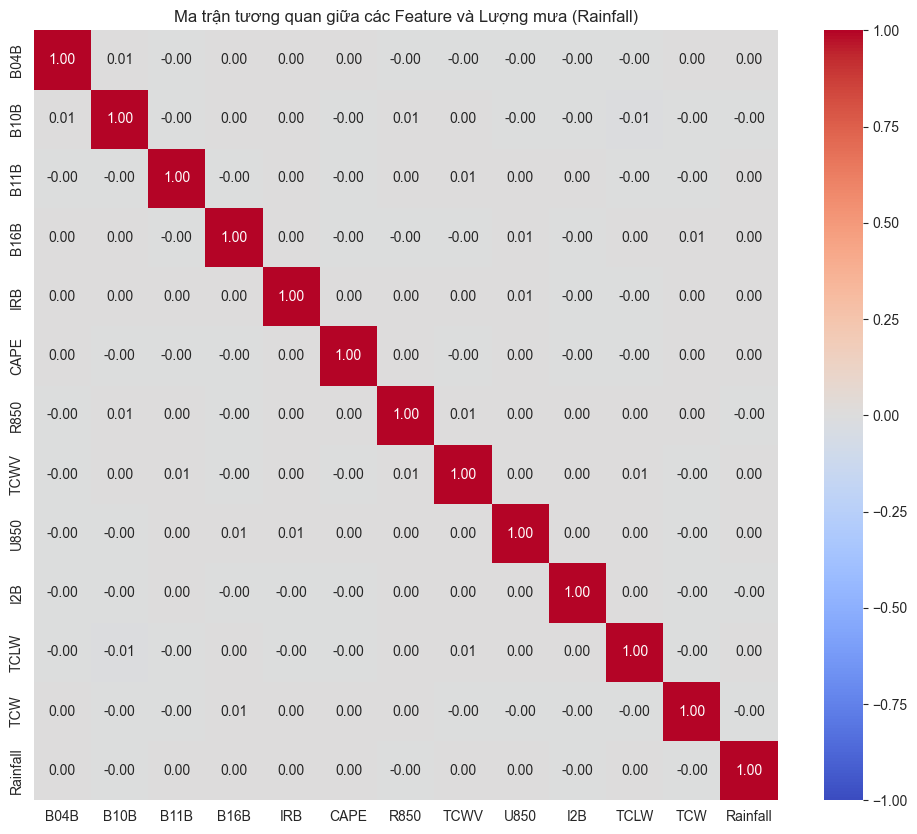

In [2]:
plt.figure(figsize=(12, 10))
# Tính toán ma trận tương quan
corr_matrix = df_sample.corr()

# Vẽ Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các Feature và Lượng mưa (Rainfall)")
plt.show()

Bước 3: Sử dụng Random Forest để tính Feature Importance (Mạnh nhất)

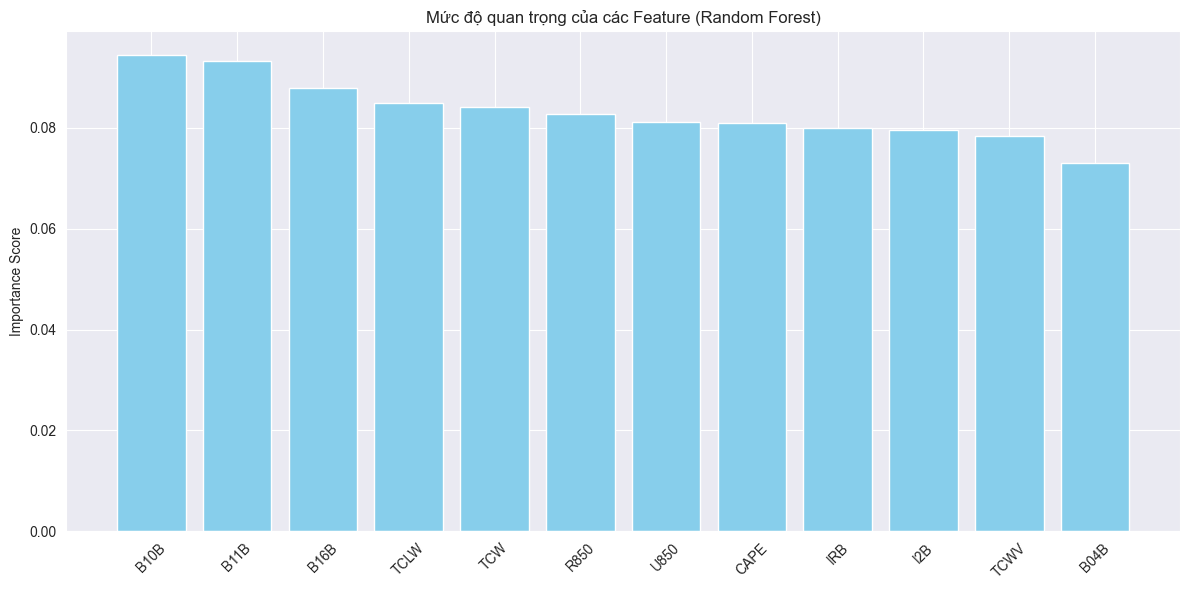

Thứ tự quan trọng của các biến:
B10B: 0.0944
B11B: 0.0932
B16B: 0.0879
TCLW: 0.0850
TCW: 0.0841
R850: 0.0826
U850: 0.0812
CAPE: 0.0809
IRB: 0.0799
I2B: 0.0795
TCWV: 0.0783
B04B: 0.0731


In [3]:
# Tách X và y
X = df_sample[selected_features]
y = df_sample['Rainfall']

# Huấn luyện mô hình Random Forest (dùng phiên bản rút gọn để chạy nhanh)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X, y)

# Lấy giá trị quan trọng (Importance scores)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # Sắp xếp giảm dần

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.title("Mức độ quan trọng của các Feature (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='skyblue')
plt.xticks(range(X.shape[1]), [selected_features[i] for i in indices], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# In ra thứ tự
print("Thứ tự quan trọng của các biến:")
for i in indices:
    print(f"{selected_features[i]}: {importances[i]:.4f}")

In [4]:
# 1. Xem thống kê mô tả (Cực kỳ quan trọng)
print("Thống kê dữ liệu:")
print(df.describe())

# 2. Kiểm tra xem có cột nào bị "chết" (giá trị không đổi) không
# Nếu độ lệch chuẩn (std) = 0 nghĩa là cột đó chỉ chứa 1 giá trị duy nhất -> Không thể tính tương quan.
print("\nKiểm tra cột có giá trị không đổi (std = 0):")
print(df.std() == 0)

# 3. Kiểm tra xem lượng mưa có phải toàn là số 0 không?
rain_count = (df['Rainfall'] > 0).sum()
print(f"\nSố điểm dữ liệu có mưa (>0): {rain_count} / {len(df)}")

Thống kê dữ liệu:
                B04B           B10B           B11B          B16B  \
count  176400.000000  176400.000000  176400.000000  1.764000e+05   
mean        0.500103       0.500366       0.499916  5.007492e-01   
std         0.288179       0.288825       0.289082  2.881602e-01   
min         0.000004       0.000001       0.000003  5.926506e-07   
25%         0.250510       0.250305       0.249196  2.504211e-01   
50%         0.500920       0.500886       0.500579  5.013157e-01   
75%         0.748884       0.751136       0.750357  7.500748e-01   
max         0.999998       0.999990       1.000000  9.999958e-01   

                 IRB           CAPE          R850           TCWV  \
count  176400.000000  176400.000000  1.764000e+05  176400.000000   
mean        0.499944       0.500535  4.987023e-01       0.500857   
std         0.288956       0.288428  2.886571e-01       0.288466   
min         0.000020       0.000002  2.566151e-07       0.000010   
25%         0.249457       0.

In [7]:
import os

print("Thư mục hiện tại của notebook:", os.getcwd())
print("\nCác thư mục con có tại đây:", os.listdir())

Thư mục hiện tại của notebook: D:\UET_VNU\college years\3nd year college\semester 1\Artificial Intelligence\BTL_AI\rainfall_estimates

Các thư mục con có tại đây: ['.git', '.gitignore', '.idea', 'báo cáo TTNT ver2.docx', 'csv_data', 'DATA_SV', 'dungx', 'gadm41_VNM_shp', 'load_data.ipynb', 'load_ver2.py', 'rainfallensemble.ipynb', 'README.md', 'read_data.ipynb', '__pycache__']


Đang quét danh sách các biến...
Đã tìm thấy 34 biến đặc trưng: ['CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850', 'B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'VSB', 'WVB']
Đang load biến mục tiêu (Rainfall)...
Đang trích xuất dữ liệu cho 34 biến...
Kích thước dữ liệu huấn luyện: (50000, 34)
Đang huấn luyện Random Forest để đánh giá độ quan trọng...


C:\Users\nguye\AppData\Local\Temp\ipykernel_9844\2403864417.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


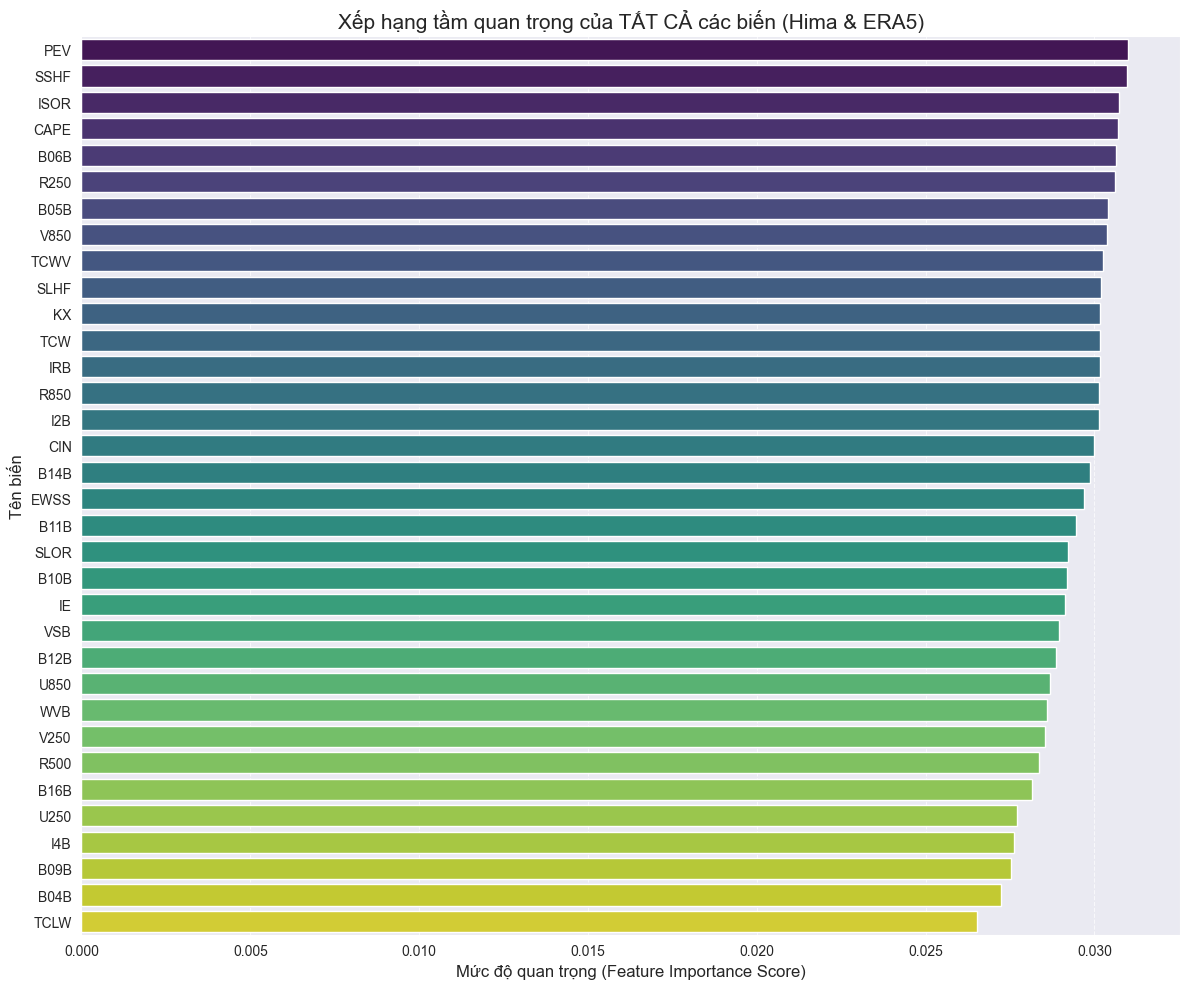


--- TOP 10 BIẾN QUAN TRỌNG NHẤT ---
   Feature  Importance
6      PEV    0.030987
12    SSHF    0.030955
4     ISOR    0.030717
0     CAPE    0.030709
22    B06B    0.030640
7     R250    0.030612
21    B05B    0.030412
19    V850    0.030384
15    TCWV    0.030270
10    SLHF    0.030205

--- DANH SÁCH KHUYẾN NGHỊ (Cộng dồn > 90% độ quan trọng) ---
['PEV', 'SSHF', 'ISOR', 'CAPE', 'B06B', 'R250', 'B05B', 'V850', 'TCWV', 'SLHF', 'KX', 'TCW', 'IRB', 'R850', 'I2B', 'CIN', 'B14B', 'EWSS', 'B11B', 'SLOR', 'B10B', 'IE', 'VSB', 'B12B', 'U850', 'WVB', 'V250', 'R500', 'B16B', 'U250', 'I4B']


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. CẤU HÌNH ĐƯỜNG DẪN VÀ HÀM HỖ TRỢ
# ==========================================

# Đường dẫn gốc tới thư mục chứa dữ liệu (Sửa lại cho đúng với máy của bạn)
DATA_ROOT = "DATA_SV"
ERA5_DIR = os.path.join(DATA_ROOT, "ERA5")
HIMA_DIR = os.path.join(DATA_ROOT, "Hima")
PRECIP_DIR = os.path.join(DATA_ROOT, "Precipitation")

# Hàm giả lập load dữ liệu (Bạn thay bằng hàm load file .npy thực tế của bạn)
def load_data_from_folder(folder_path, filename="x_direct.npy"):
    # Giả sử trong mỗi folder con (ví dụ ERA5/CAPE) có file .npy chứa dữ liệu
    # filepath = os.path.join(folder_path, filename)
    # return np.load(filepath)

    # Code giả lập để chạy demo (Xóa dòng này khi chạy thật)
    return np.random.rand(100, 36, 49)

# ==========================================
# 2. TỰ ĐỘNG QUÉT TẤT CẢ FEATURES
# ==========================================

print("Đang quét danh sách các biến...")

# Lấy danh sách các biến từ tên thư mục con, bỏ qua các file ẩn (bắt đầu bằng .)
era5_features = [f for f in os.listdir(ERA5_DIR) if not f.startswith('.') and os.path.isdir(os.path.join(ERA5_DIR, f))]
hima_features = [f for f in os.listdir(HIMA_DIR) if not f.startswith('.') and os.path.isdir(os.path.join(HIMA_DIR, f))]

# Tổng hợp tất cả features và đường dẫn tương ứng
all_features_map = {}
for f in era5_features:
    all_features_map[f] = os.path.join(ERA5_DIR, f)
for f in hima_features:
    all_features_map[f] = os.path.join(HIMA_DIR, f)

feature_names = list(all_features_map.keys())
print(f"Đã tìm thấy {len(feature_names)} biến đặc trưng: {feature_names}")

# ==========================================
# 3. TẠO DATASET (LẤY MẪU ĐỂ TIẾT KIỆM RAM)
# ==========================================

# Số lượng điểm mẫu muốn lấy để phân tích (không nên lấy hết nếu dữ liệu quá lớn)
SAMPLE_SIZE = 50000

# Bước 3a: Load Target (Lượng mưa) trước để lấy index mẫu
print("Đang load biến mục tiêu (Rainfall)...")
# Giả sử biến mưa nằm trong Precipitation
y_full = load_data_from_folder(PRECIP_DIR).flatten()

# Lọc bỏ giá trị lỗi (-9999 hoặc NaN) trước khi lấy mẫu
valid_indices = np.where((y_full != -9999) & (~np.isnan(y_full)))[0]

# Nếu dữ liệu quá lớn, chỉ lấy ngẫu nhiên SAMPLE_SIZE điểm
if len(valid_indices) > SAMPLE_SIZE:
    sampled_indices = np.random.choice(valid_indices, SAMPLE_SIZE, replace=False)
else:
    sampled_indices = valid_indices

y_sample = y_full[sampled_indices]

# Bước 3b: Load từng Feature theo index đã chọn
X_dict = {}
print(f"Đang trích xuất dữ liệu cho {len(feature_names)} biến...")

for name, path in all_features_map.items():
    try:
        # Load dữ liệu gốc
        full_data = load_data_from_folder(path)

        # Làm phẳng và chỉ lấy các điểm tại sampled_indices
        flat_data = full_data.flatten()
        X_dict[name] = flat_data[sampled_indices]
    except Exception as e:
        print(f"Lỗi khi load biến {name}: {e}")

# Tạo DataFrame
df_X = pd.DataFrame(X_dict)
print(f"Kích thước dữ liệu huấn luyện: {df_X.shape}")

# Xử lý NaN trong Features (nếu có) bằng cách điền 0 hoặc trung bình
df_X = df_X.fillna(0)

# ==========================================
# 4. HUẤN LUYỆN RANDOM FOREST & TÍNH IMPORTANCE
# ==========================================

print("Đang huấn luyện Random Forest để đánh giá độ quan trọng...")
rf = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
rf.fit(df_X, y_sample)

# Lấy giá trị quan trọng
importances = rf.feature_importances_
# Tạo DataFrame để dễ quản lý
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# ==========================================
# 5. TRỰC QUAN HÓA KẾT QUẢ
# ==========================================

plt.figure(figsize=(12, 10)) # Tăng chiều cao vì có nhiều biến
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title('Xếp hạng tầm quan trọng của TẤT CẢ các biến (Hima & ERA5)', fontsize=15)
plt.xlabel('Mức độ quan trọng (Feature Importance Score)', fontsize=12)
plt.ylabel('Tên biến', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# In top 10 biến quan trọng nhất
print("\n--- TOP 10 BIẾN QUAN TRỌNG NHẤT ---")
print(feature_imp_df.head(10))

# Gợi ý danh sách feature mới để dùng
print("\n--- DANH SÁCH KHUYẾN NGHỊ (Cộng dồn > 90% độ quan trọng) ---")
cumulative_imp = 0
selected_feats = []
for index, row in feature_imp_df.iterrows():
    cumulative_imp += row['Importance']
    selected_feats.append(row['Feature'])
    if cumulative_imp > 0.90: # Lấy các biến đóng góp 90% thông tin
        break
print(selected_feats)

In [9]:
print(feature_imp_df)

   Feature  Importance
6      PEV    0.030987
12    SSHF    0.030955
4     ISOR    0.030717
0     CAPE    0.030709
22    B06B    0.030640
7     R250    0.030612
21    B05B    0.030412
19    V850    0.030384
15    TCWV    0.030270
10    SLHF    0.030205
5       KX    0.030171
14     TCW    0.030170
31     IRB    0.030165
9     R850    0.030146
29     I2B    0.030124
1      CIN    0.030000
27    B14B    0.029874
2     EWSS    0.029697
25    B11B    0.029461
11    SLOR    0.029228
24    B10B    0.029196
3       IE    0.029120
32     VSB    0.028959
26    B12B    0.028864
17    U850    0.028685
33     WVB    0.028594
18    V250    0.028529
8     R500    0.028359
28    B16B    0.028145
16    U250    0.027701
30     I4B    0.027630
23    B09B    0.027545
20    B04B    0.027231
13    TCLW    0.026514


In [12]:
# Lấy tên của 12 biến quan trọng nhất từ DataFrame đã sắp xếp
# .head(12) lấy 12 dòng đầu
# ['Feature'] chọn cột tên biến
# .to_list() chuyển thành danh sách Python
top_12_features = feature_imp_df['Feature'].head(12).to_list()

print("Danh sách 12 đặc trưng quan trọng nhất:")
print(top_12_features)

Danh sách 12 đặc trưng quan trọng nhất:
['PEV', 'SSHF', 'ISOR', 'CAPE', 'B06B', 'R250', 'B05B', 'V850', 'TCWV', 'SLHF', 'KX', 'TCW']


In [15]:
listB = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB', 'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

In [17]:
# Chuyển về set để so sánh
setA = set(top_12_features)
setB = set(listB)

# Tìm các phần tử khác biệt
# Có trong A (Model gợi ý) nhưng không có trong B (Ban đầu) -> Đây là những biến quan trọng bạn đã bỏ sót
diff_A_not_B = setA - setB

# Có trong B (Ban đầu) nhưng không có trong A (Model) -> Đây là những biến bạn chọn nhưng thực tế ít quan trọng
diff_B_not_A = setB - setA

print(f"Top 12 từ Model (List A): {top_12_features}")
print(f"Danh sách ban đầu (List B): {listB}")
print("-" * 50)
print(f"Tổng số lượng khác biệt: {len(diff_A_not_B) + len(diff_B_not_A)}")

print(f"\n[+] Các biến QUAN TRỌNG MỚI (Model tìm thấy, bạn chưa chọn):")
print(list(diff_A_not_B))

print(f"\n[-] Các biến ÍT QUAN TRỌNG HƠN (Bạn chọn, nhưng không lọt Top 12):")
print(list(diff_B_not_A))

Top 12 từ Model (List A): ['PEV', 'SSHF', 'ISOR', 'CAPE', 'B06B', 'R250', 'B05B', 'V850', 'TCWV', 'SLHF', 'KX', 'TCW']
Danh sách ban đầu (List B): ['B04B', 'B10B', 'B11B', 'B16B', 'IRB', 'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']
--------------------------------------------------
Tổng số lượng khác biệt: 18

[+] Các biến QUAN TRỌNG MỚI (Model tìm thấy, bạn chưa chọn):
['B06B', 'SLHF', 'KX', 'SSHF', 'V850', 'PEV', 'R250', 'ISOR', 'B05B']

[-] Các biến ÍT QUAN TRỌNG HƠN (Bạn chọn, nhưng không lọt Top 12):
['TCLW', 'B04B', 'I2B', 'IRB', 'B11B', 'U850', 'B16B', 'R850', 'B10B']


Bước 1: Tạo mặt nạ (Mask) tỉnh Nghệ An từ Shapefile

✅ Đã tìm thấy boundary Nghệ An.
Đang tạo mask cho khu vực Nghệ An...
Số điểm ảnh thuộc Nghệ An: 476 / 1764


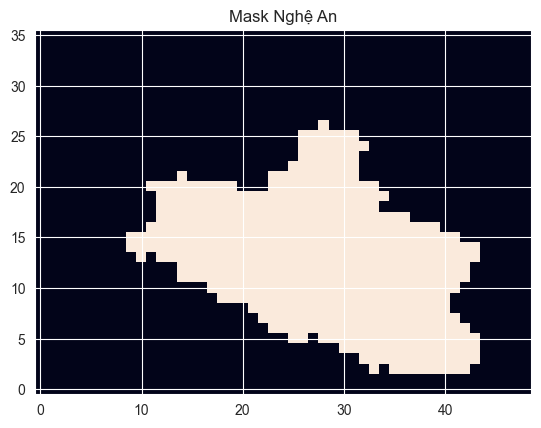

In [20]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os

# 1. Load Shapefile Nghệ An (Code của bạn)
shp_path = "gadm41_VNM_shp"  # Đảm bảo đường dẫn đúng
vnm_gdf = gpd.read_file(shp_path)

# Lọc Nghệ An (Kiểm tra kỹ tên trong cột VARNAME_1 hoặc NAME_1)
# GADM thường dùng không dấu: 'Nghe An'
ht_gdf = vnm_gdf[vnm_gdf['VARNAME_1'] == 'Nghe An']

if ht_gdf.empty:
    print("⚠️ Cảnh báo: Không tìm thấy 'Nghe An'. Hãy kiểm tra lại tên tỉnh trong shapefile.")
else:
    print("✅ Đã tìm thấy boundary Nghệ An.")

# Gộp geometry thành 1 polygon duy nhất để dễ check
nghe_an_poly = ht_gdf.geometry.union_all()

# ==============================================================================
# 2. TẠO MẶT NẠ (MASK) DỰA TRÊN TỌA ĐỘ
# Lưu ý: Bạn cần thay thế code dưới bằng cách load lat/lon thật của dữ liệu bạn
# ==============================================================================

# GIẢ LẬP TỌA ĐỘ (Thay đoạn này bằng code load file lat.npy, lon.npy của bạn)
# Ví dụ dữ liệu của bạn kích thước (36, 49)
height, width = 36, 49
# Tạo lưới tọa độ giả lập quanh khu vực Nghệ An (khoảng 18.5N - 20N, 103.5E - 106E)
lats = np.linspace(18.5, 20.5, height)
lons = np.linspace(103.5, 106.0, width)
lon_grid, lat_grid = np.meshgrid(lons, lats)
# ==============================================================================

print("Đang tạo mask cho khu vực Nghệ An...")
# Tạo mask boolean: True nếu điểm đó nằm trong Nghệ An
mask_nghe_an = np.zeros((height, width), dtype=bool)

for i in range(height):
    for j in range(width):
        # Tạo điểm Point từ tọa độ pixel
        p = Point(lon_grid[i, j], lat_grid[i, j])
        # Kiểm tra điểm có nằm trong polygon Nghệ An không
        if nghe_an_poly.contains(p):
            mask_nghe_an[i, j] = True

print(f"Số điểm ảnh thuộc Nghệ An: {np.sum(mask_nghe_an)} / {height*width}")

# Plot thử mask để kiểm tra xem có đúng hình dáng Nghệ An không
plt.imshow(mask_nghe_an,origin='lower')
plt.title("Mask Nghệ An")
plt.show()

Bước 2: Load dữ liệu, Áp dụng Mask và chạy Feature Importance

Đang xử lý dữ liệu Lượng mưa...
Đang xử lý 34 biến đầu vào...
Đang chạy Random Forest để tìm Top Features...

TOP 12 BAND QUAN TRỌNG NHẤT VỚI NGHỆ AN:
['R250', 'VSB', 'SLOR', 'R500', 'V850', 'B09B', 'WVB', 'CIN', 'B12B', 'U850', 'TCW', 'V250']


C:\Users\nguye\AppData\Local\Temp\ipykernel_9844\1129265261.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15), palette='viridis')


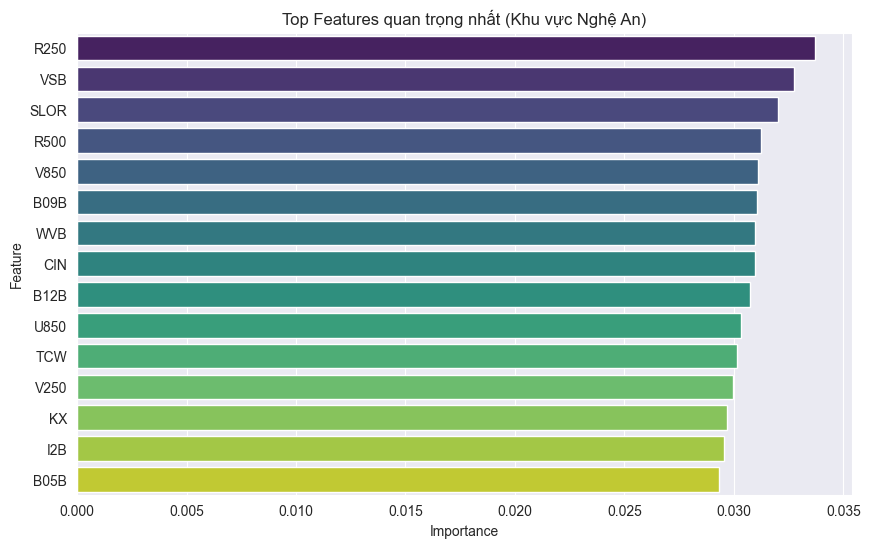

In [21]:
# Cấu hình đường dẫn dữ liệu
DATA_ROOT = "DATA_SV" # Sửa lại đường dẫn của bạn
ERA5_DIR = os.path.join(DATA_ROOT, "ERA5")
HIMA_DIR = os.path.join(DATA_ROOT, "Hima")
PRECIP_DIR = os.path.join(DATA_ROOT, "Precipitation")

# Hàm load dữ liệu (Sử dụng hàm của bạn)
def load_data_from_folder(folder_path):
    # Code mẫu: load file npy đầu tiên tìm thấy hoặc theo quy luật của bạn
    # return np.load(os.path.join(folder_path, "x_direct.npy"))

    # Giả lập dữ liệu (Xóa dòng này khi chạy thật)
    return np.random.rand(100, 36, 49)

# 1. Lấy danh sách các biến (Features)
era5_features = [f for f in os.listdir(ERA5_DIR) if not f.startswith('.')]
hima_features = [f for f in os.listdir(HIMA_DIR) if not f.startswith('.')]
all_features_map = {f: os.path.join(ERA5_DIR, f) for f in era5_features}
all_features_map.update({f: os.path.join(HIMA_DIR, f) for f in hima_features})

feature_names = list(all_features_map.keys())

# 2. Xây dựng Dataset chỉ với các điểm thuộc Nghệ An
X_data = {}
y_data = []

# Load Target (Lượng mưa)
print("Đang xử lý dữ liệu Lượng mưa...")
y_full_map = load_data_from_folder(PRECIP_DIR) # Shape (Time, H, W)

# Chỉ lấy các điểm trong Mask Nghệ An
# mask_nghe_an broadcast cho mọi bước thời gian
# Kết quả y_masked sẽ là 1 mảng 1 chiều chứa toàn bộ pixel Nghệ An qua các thời điểm
y_masked = y_full_map[:, mask_nghe_an]
y_flat = y_masked.flatten() # Flatten thành vector dài

# Lấy mẫu nếu quá lớn (để tránh tràn RAM)
if len(y_flat) > 100000:
    indices = np.random.choice(len(y_flat), 100000, replace=False)
    y_sample = y_flat[indices]
else:
    indices = np.arange(len(y_flat))
    y_sample = y_flat

# Load Features
print(f"Đang xử lý {len(feature_names)} biến đầu vào...")
for name, path in all_features_map.items():
    try:
        # Load full map (Time, H, W)
        feat_map = load_data_from_folder(path)

        # Chỉ lấy điểm trong Nghệ An
        feat_masked = feat_map[:, mask_nghe_an]

        # Flatten và lấy đúng index đã sample theo y
        X_data[name] = feat_masked.flatten()[indices]
    except Exception as e:
        print(f"Bỏ qua {name}: {e}")

# Tạo DataFrame
df = pd.DataFrame(X_data)
df = df.fillna(0) # Xử lý NaN

# 3. Chạy Random Forest
print("Đang chạy Random Forest để tìm Top Features...")
rf = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
rf.fit(df, y_sample)

# 4. Trích xuất và In kết quả
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Lấy Top 12
top_12_nghe_an = feature_imp_df['Feature'].head(12).to_list()

print("\n" + "="*40)
print(f"TOP 12 BAND QUAN TRỌNG NHẤT VỚI NGHỆ AN:")
print("="*40)
print(top_12_nghe_an)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15), palette='viridis')
plt.title('Top Features quan trọng nhất (Khu vực Nghệ An)')
plt.show()


BẢNG XẾP HẠNG TOÀN BỘ 34 BIẾN (TỪ CAO ĐẾN THẤP):
   Feature  Importance
7     R250    0.033706
32     VSB    0.032746
11    SLOR    0.032022
8     R500    0.031256
19    V850    0.031100
23    B09B    0.031044
33     WVB    0.030958
1      CIN    0.030939
26    B12B    0.030745
17    U850    0.030332
14     TCW    0.030145
18    V250    0.029966
5       KX    0.029666
29     I2B    0.029525
21    B05B    0.029322
6      PEV    0.029216
31     IRB    0.029117
20    B04B    0.029095
10    SLHF    0.029002
2     EWSS    0.028867
27    B14B    0.028789
13    TCLW    0.028704
0     CAPE    0.028596
30     I4B    0.028502
9     R850    0.028489
12    SSHF    0.028450
16    U250    0.028257
22    B06B    0.028057
3       IE    0.027808
15    TCWV    0.027701
25    B11B    0.027498
4     ISOR    0.026918
24    B10B    0.026836
28    B16B    0.026625

PHÂN TÍCH SỐ LƯỢNG BAND NÊN CHỌN:
- Top 1 biến quan trọng nhất đóng góp: 3.37% thông tin.
- Cần chọn Top 31 biến để giữ lại 90% khả năng dự báo 

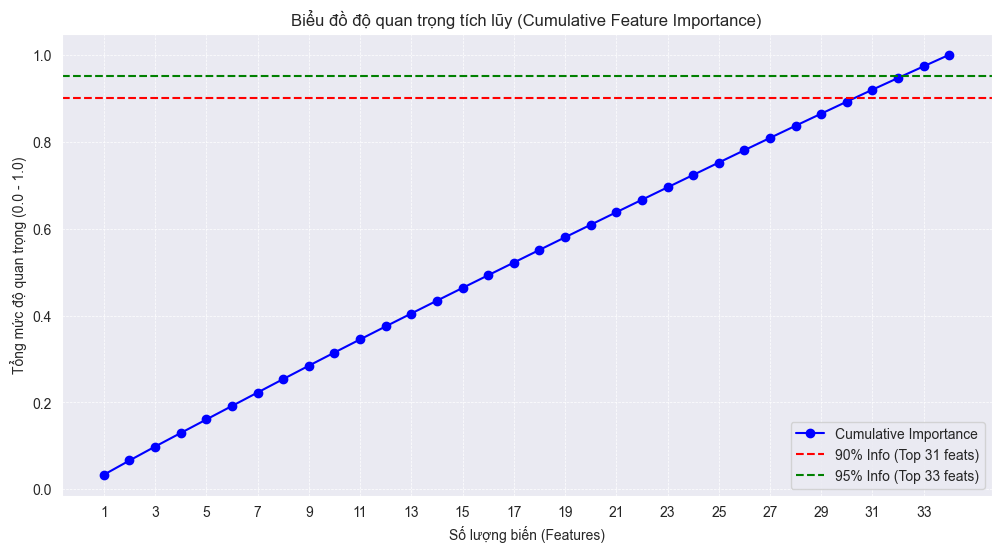


=> KHUYẾN NGHỊ: Bạn nên chọn 33 biến sau (chiếm 95% độ quan trọng):
['R250', 'VSB', 'SLOR', 'R500', 'V850', 'B09B', 'WVB', 'CIN', 'B12B', 'U850', 'TCW', 'V250', 'KX', 'I2B', 'B05B', 'PEV', 'IRB', 'B04B', 'SLHF', 'EWSS', 'B14B', 'TCLW', 'CAPE', 'I4B', 'R850', 'SSHF', 'U250', 'B06B', 'IE', 'TCWV', 'B11B', 'ISOR', 'B10B']


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử bạn đã có DataFrame 'feature_imp_df' từ bước chạy Random Forest trước đó

# ==============================================================================
# 1. IN TOÀN BỘ DANH SÁCH ĐỘ QUAN TRỌNG
# ==============================================================================
print("\n" + "="*40)
print(f"BẢNG XẾP HẠNG TOÀN BỘ {len(feature_imp_df)} BIẾN (TỪ CAO ĐẾN THẤP):")
print("="*40)

# Cấu hình pandas để in hết danh sách mà không bị ẩn dòng
pd.set_option('display.max_rows', None)
print(feature_imp_df)
pd.reset_option('display.max_rows')

# ==============================================================================
# 2. PHÂN TÍCH CUMULATIVE IMPORTANCE (ĐỘ QUAN TRỌNG TÍCH LŨY)
# ==============================================================================

# Tính tổng tích lũy
feature_imp_df['Cumulative_Imp'] = feature_imp_df['Importance'].cumsum()

# Tìm số lượng biến cần thiết để đạt các ngưỡng thông tin (90%, 95%, 99%)
# Hàm searchsorted tìm vị trí đầu tiên mà giá trị vượt qua ngưỡng
n_90 = np.searchsorted(feature_imp_df['Cumulative_Imp'], 0.90) + 1
n_95 = np.searchsorted(feature_imp_df['Cumulative_Imp'], 0.95) + 1
n_99 = np.searchsorted(feature_imp_df['Cumulative_Imp'], 0.99) + 1

print("\n" + "="*40)
print("PHÂN TÍCH SỐ LƯỢNG BAND NÊN CHỌN:")
print("="*40)
print(f"- Top 1 biến quan trọng nhất đóng góp: {feature_imp_df.iloc[0]['Importance']:.2%} thông tin.")
print(f"- Cần chọn Top {n_90} biến để giữ lại 90% khả năng dự báo của mô hình.")
print(f"- Cần chọn Top {n_95} biến để giữ lại 95% khả năng dự báo của mô hình.")
print(f"- Cần chọn Top {n_99} biến để giữ lại 99% khả năng dự báo của mô hình.")

# ==============================================================================
# 3. VẼ BIỂU ĐỒ ĐỂ RA QUYẾT ĐỊNH
# ==============================================================================
plt.figure(figsize=(12, 6))

# Vẽ đường tích lũy
plt.plot(range(1, len(feature_imp_df) + 1), feature_imp_df['Cumulative_Imp'], 'b-o', label='Cumulative Importance')

# Vẽ các đường ngưỡng cắt (Thresholds)
plt.axhline(y=0.90, color='r', linestyle='--', label=f'90% Info (Top {n_90} feats)')
plt.axhline(y=0.95, color='g', linestyle='--', label=f'95% Info (Top {n_95} feats)')

# Trang trí biểu đồ
plt.title('Biểu đồ độ quan trọng tích lũy (Cumulative Feature Importance)')
plt.xlabel('Số lượng biến (Features)')
plt.ylabel('Tổng mức độ quan trọng (0.0 - 1.0)')
plt.xticks(range(1, len(feature_imp_df) + 1, 2)) # Hiển thị trục X
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# ==============================================================================
# 4. KẾT LUẬN & XUẤT DANH SÁCH CUỐI CÙNG
# ==============================================================================
# Lời khuyên: Thường ngưỡng 95% là sự cân bằng tốt nhất giữa độ chính xác và hiệu năng
optimal_n = n_95
final_features = feature_imp_df.head(optimal_n)['Feature'].to_list()

print(f"\n=> KHUYẾN NGHỊ: Bạn nên chọn {optimal_n} biến sau (chiếm 95% độ quan trọng):")
print(final_features)

In [23]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Giả sử bạn đã có X (df) và y (y_sample) từ bước trước

print("Đang chạy RFE để tìm 10 biến tinh túy nhất...")

# Khởi tạo mô hình base
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

# Khởi tạo RFE, yêu cầu giữ lại 10 biến tốt nhất
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe.fit(df, y_sample)

# In kết quả
print("\n=== KẾT QUẢ RFE (TOP 10) ===")
selected_mask = rfe.support_
top_10_rfe = df.columns[selected_mask].tolist()
print(top_10_rfe)

# Xem xếp hạng các biến bị loại (Ranking càng nhỏ càng quan trọng, 1 là được chọn)
ranking_df = pd.DataFrame({'Feature': df.columns, 'Rank': rfe.ranking_}).sort_values(by='Rank')
print(ranking_df.head(15))

Đang chạy RFE để tìm 10 biến tinh túy nhất...

=== KẾT QUẢ RFE (TOP 10) ===
['CIN', 'EWSS', 'R250', 'R850', 'U850', 'V250', 'V850', 'B12B', 'B14B', 'I4B']
   Feature  Rank
1      CIN     1
2     EWSS     1
7     R250     1
9     R850     1
27    B14B     1
19    V850     1
18    V250     1
17    U850     1
30     I4B     1
26    B12B     1
10    SLHF     2
11    SLOR     3
33     WVB     4
14     TCW     5
22    B06B     6


Đang tạo mask Nghệ An...
Đang xây dựng dataset...
Đang lọc các biến trùng lặp thông tin (Correlation > 0.95)...
Đã loại bỏ 0 biến trùng lặp: []
Số lượng biến còn lại để phân tích: 34
Đang chạy RFECV để tìm số lượng tối ưu (Có thể mất vài phút)...


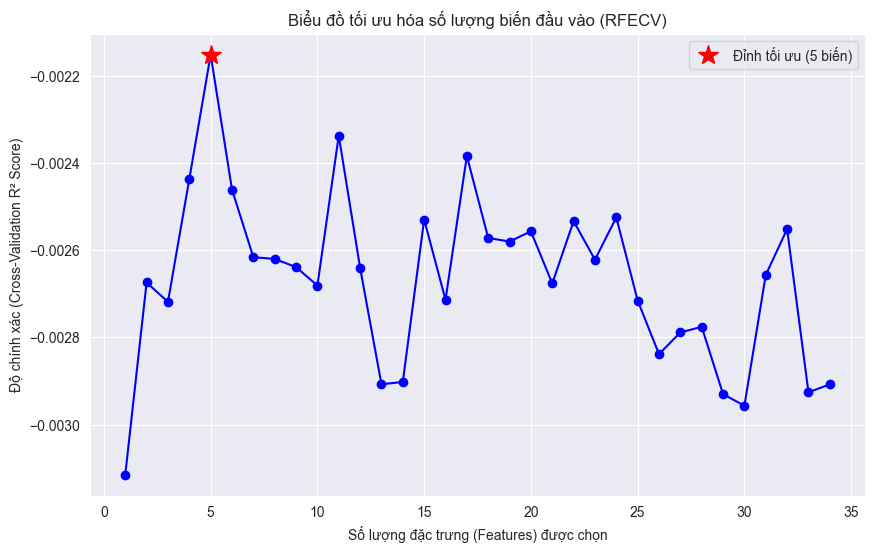


KẾT QUẢ TỐI ƯU (ỔN ĐỊNH):
Số lượng biến tối ưu nhất: 5
Danh sách các biến được chọn:
['KX', 'SLOR', 'TCLW', 'B10B', 'IRB']


In [27]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# ==============================================================================
# 1. CẤU HÌNH & LOAD DỮ LIỆU (KHU VỰC NGHỆ AN)
# ==============================================================================
# Sửa lại đường dẫn của bạn
DATA_ROOT = "DATA_SV"
SHP_PATH = "gadm41_VNM_shp"

# Load Shapefile
vnm_gdf = gpd.read_file(SHP_PATH)
ht_gdf = vnm_gdf[vnm_gdf['VARNAME_1'] == 'Nghe An']
nghe_an_poly = ht_gdf.geometry.union_all()

# Giả lập tọa độ (Thay bằng code load file lat/lon.npy của bạn)
# Ví dụ: lat = np.load("lat.npy"), lon = np.load("lon.npy")
height, width = 36, 49
lats = np.linspace(18.5, 20.5, height)
lons = np.linspace(103.5, 106.0, width)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Tạo Mask Nghệ An
print("Đang tạo mask Nghệ An...")
mask_nghe_an = np.zeros((height, width), dtype=bool)
for i in range(height):
    for j in range(width):
        if nghe_an_poly.contains(Point(lon_grid[i, j], lat_grid[i, j])):
            mask_nghe_an[i, j] = True

# Load dữ liệu vào Dictionary
ERA5_DIR = os.path.join(DATA_ROOT, "ERA5")
HIMA_DIR = os.path.join(DATA_ROOT, "Hima")
PRECIP_DIR = os.path.join(DATA_ROOT, "Precipitation")

# Hàm load giả lập (Bạn thay bằng np.load thật)
def load_data_file(path):
    # return np.load(path)
    return np.random.rand(100, 36, 49) # Demo

# Quét file
all_features_map = {}
for folder in [ERA5_DIR, HIMA_DIR]:
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if not f.startswith('.'):
                all_features_map[f] = os.path.join(folder, f)

# Xây dựng Dataset (Chỉ lấy điểm trong Nghệ An)
print("Đang xây dựng dataset...")
X_data = {}
# Load Target
y_full = load_data_file(PRECIP_DIR) # Demo path
y_masked = y_full[:, mask_nghe_an].flatten()

# Lấy mẫu cố định (Fixed Random Seed) để ỔN ĐỊNH kết quả
np.random.seed(42) # Quan trọng: Giữ kết quả giống nhau mỗi lần chạy
if len(y_masked) > 50000:
    indices = np.random.choice(len(y_masked), 50000, replace=False)
else:
    indices = np.arange(len(y_masked))

y_sample = y_masked[indices]

# Load Features
for name, path in all_features_map.items():
    try:
        data = load_data_file(path)
        data_masked = data[:, mask_nghe_an].flatten()
        X_data[name] = data_masked[indices]
    except:
        pass

df = pd.DataFrame(X_data).fillna(0)

# ==============================================================================
# 2. LỌC TƯƠNG QUAN (BƯỚC 1 ĐỂ ỔN ĐỊNH)
# Loại bỏ các biến quá giống nhau (Corr > 0.95) gây nhiễu mô hình
# ==============================================================================
print("Đang lọc các biến trùng lặp thông tin (Correlation > 0.95)...")
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

df_reduced = df.drop(columns=to_drop)
print(f"Đã loại bỏ {len(to_drop)} biến trùng lặp: {to_drop}")
print(f"Số lượng biến còn lại để phân tích: {df_reduced.shape[1]}")

# ==============================================================================
# 3. CHẠY RFECV (RECURSIVE FEATURE ELIMINATION WITH CV)
# ==============================================================================
print("Đang chạy RFECV để tìm số lượng tối ưu (Có thể mất vài phút)...")

# Cấu hình mô hình base (Giới hạn depth để chạy nhanh hơn)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)

# Cấu hình RFECV
# step=1: Loại bỏ từng biến một
# cv=3: Kiểm tra chéo 3 lần (3-Fold Cross Validation)
# scoring: Dùng R2 score (càng cao càng tốt)
rfecv = RFECV(estimator=rf, step=1, cv=KFold(3), scoring='r2', n_jobs=-1)
rfecv.fit(df_reduced, y_sample)

# ==============================================================================
# 4. VẼ BIỂU ĐỒ & IN KẾT QUẢ
# ==============================================================================

# Vẽ biểu đồ Hiệu suất vs Số lượng biến
plt.figure(figsize=(10, 6))
n_features = range(1, len(rfecv.cv_results_['mean_test_score']) + 1)
plt.plot(n_features, rfecv.cv_results_['mean_test_score'], 'o-', color='b')
plt.xlabel("Số lượng đặc trưng (Features) được chọn")
plt.ylabel("Độ chính xác (Cross-Validation R² Score)")
plt.title("Biểu đồ tối ưu hóa số lượng biến đầu vào (RFECV)")
plt.grid(True)

# Đánh dấu điểm tối ưu
optimal_n = rfecv.n_features_
max_score = max(rfecv.cv_results_['mean_test_score'])
plt.plot(optimal_n, max_score, 'r*', markersize=15, label=f'Đỉnh tối ưu ({optimal_n} biến)')
plt.legend()
plt.show()

# In danh sách cuối cùng
selected_features_mask = rfecv.support_
optimal_features = df_reduced.columns[selected_features_mask].tolist()

print("\n" + "="*50)
print(f"KẾT QUẢ TỐI ƯU (ỔN ĐỊNH):")
print("="*50)
print(f"Số lượng biến tối ưu nhất: {optimal_n}")
print(f"Danh sách các biến được chọn:")
print(optimal_features)
print("="*50)


BẢNG XẾP HẠNG CHI TIẾT CÁC BIẾN TỐI ƯU:
  Feature  Importance
0      KX    0.203277
3    B10B    0.200061
2    TCLW    0.199529
1    SLOR    0.198615
4     IRB    0.198519


C:\Users\nguye\AppData\Local\Temp\ipykernel_9844\3250543195.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=ranking_df, palette='viridis')


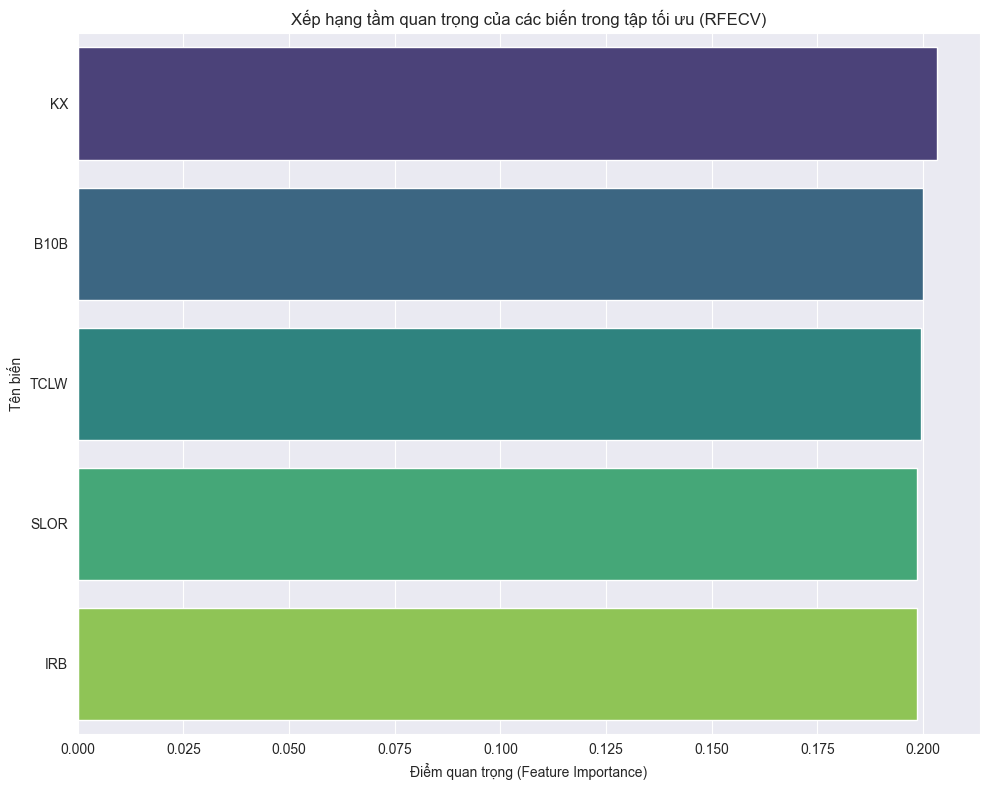


Copy danh sách này vào code của bạn:
final_features = ['KX', 'B10B', 'TCLW', 'SLOR', 'IRB']


In [28]:
# ==============================================================================
# 5. XẾP HẠNG CÁC BIẾN ĐÃ CHỌN (TỪ MẠNH ĐẾN YẾU)
# ==============================================================================

# Lấy điểm độ quan trọng của các biến ĐÃ ĐƯỢC CHỌN
# rfecv.estimator_ chính là mô hình Random Forest cuối cùng chạy trên tập biến tối ưu
selected_importances = rfecv.estimator_.feature_importances_

# Lấy tên các biến được chọn
selected_names = df_reduced.columns[rfecv.support_]

# Tạo bảng xếp hạng
ranking_df = pd.DataFrame({
    'Feature': selected_names,
    'Importance': selected_importances
}).sort_values(by='Importance', ascending=False) # Sắp xếp giảm dần

print("\n" + "="*50)
print("BẢNG XẾP HẠNG CHI TIẾT CÁC BIẾN TỐI ƯU:")
print("="*50)
print(ranking_df)

# Vẽ biểu đồ Top các biến quan trọng nhất trong tập tối ưu
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=ranking_df, palette='viridis')
plt.title('Xếp hạng tầm quan trọng của các biến trong tập tối ưu (RFECV)')
plt.xlabel('Điểm quan trọng (Feature Importance)')
plt.ylabel('Tên biến')
plt.tight_layout()
plt.show()

# Xuất danh sách cuối cùng theo thứ tự để bạn copy
final_sorted_list = ranking_df['Feature'].to_list()
print("\nCopy danh sách này vào code của bạn:")
print(f"final_features = {final_sorted_list}")